# Kickstarter Projects

## 目的変数：state【成功（successful）するか、失敗（failed）するか】

In [138]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
import seaborn as sns
import sklearn.preprocessing as sp
from sklearn.metrics import mean_squared_error, mean_absolute_error
from  sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

In [139]:
%%html
<style>
table {float:left}
</style>

|  カラム  |  意味  |
| ---- | ---- |
|  ID  |  キックスタータID  |
|  name  |  プロジェクト名  |
|  category  |  カテゴリ  |
|  main_category  |  キャンペーンのカテゴリ  |
|  currency  |  支援通貨  |
|  deadline  |  クラウドファンディングの締切  |
|  goal  |  資金調達目標 - 作成者がプロジェクトを完了するために必要な金額  |
|  launched  |  開始日  |
|  pledged  |  「群衆」が約束した金額  |
|  state  |  プロジェクトの現状  |
|  backers  |  支持者の数  |
|  country  |  国  |
|  usd pledged  |  USドル換算額 (conversion made by KS)  |
|  usd_pledged_real  |  USドル換算額 (conversion made by fixer.io api)  |
|  usd_goal_real  |  目標額USドル (conversion made by fixer.io api)  |

In [144]:
# データ読込
# df_cloud = pd.read_csv(
#     "./kickstarter-projects/ks-projects-201801.csv", dtype = None, delimiter = ",")[
#     ['name', 'category', 'main_category', 'currency', 'deadline', 'goal', 'launched', 'pledged', 'state', 'backers', 'country', 'usd pledged', 'usd_pledged_real', 'usd_goal_real']]
df_cloud = pd.read_csv(
    "./input/ks-projects-201801.csv", delimiter = ",")[
    ['category', 'main_category', 'currency', 'goal', 'pledged', 'state', 'backers', 'country', 'usd pledged', 'usd_pledged_real', 'usd_goal_real']]

In [145]:
#目的変数の把握
print(df_cloud['state'].value_counts(dropna=False))
print(df_cloud['state'].value_counts(normalize=True, dropna=False))

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64
failed        0.522153
successful    0.353762
canceled      0.102411
undefined     0.009407
live          0.007392
suspended     0.004875
Name: state, dtype: float64


canceled/undefined/live/suspendedは予測対象から除外

In [146]:
#成功と失敗の二値に分類

#stateを文字列から数値型へ
def statetype(in_string):
    if in_string == "successful":
        return 0
    elif in_string == "failed":
        return 1
    else :
        pass
        
df_cloud['state_num']= df_cloud['state'].apply(statetype)

# 読込データの確認
df_cloud.info()
display(df_cloud.head())
df_cloud.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 12 columns):
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
goal                378661 non-null float64
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
state_num           331675 non-null float64
dtypes: float64(6), int64(1), object(5)
memory usage: 34.7+ MB


,category,main_category,currency,goal,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,state_num
0,Poetry,Publishing,GBP,1000.0,0.0,failed,0,GB,0.0,0.0,1533.95,1.0
1,Narrative Film,Film & Video,USD,30000.0,2421.0,failed,15,US,100.0,2421.0,30000.00,1.0
2,Narrative Film,Film & Video,USD,45000.0,220.0,failed,3,US,220.0,220.0,45000.00,1.0
3,Music,Music,USD,5000.0,1.0,failed,1,US,1.0,1.0,5000.00,1.0
4,Film & Video,Film & Video,USD,19500.0,1283.0,canceled,14,US,1283.0,1283.0,19500.00,NaN


,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real,state_num
count,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05,331675.000000
mean,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04,0.596123
std,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06,0.490674
min,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02,0.000000
25%,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03,0.000000
50%,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03,1.000000
75%,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04,1.000000
max,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08,1.000000


In [147]:
print(df_cloud['country'].value_counts(normalize=True, dropna=False))

US      0.772794
GB      0.088924
CA      0.038969
AU      0.020702
DE      0.011015
N,0"    0.010027
FR      0.007762
IT      0.007600
NL      0.007574
ES      0.006011
SE      0.004640
MX      0.004627
NZ      0.003821
DK      0.002939
IE      0.002142
CH      0.002010
NO      0.001870
HK      0.001632
BE      0.001629
AT      0.001577
SG      0.001466
LU      0.000164
JP      0.000106
Name: country, dtype: float64


ほとんどがUS
欠損データ（N,0"）があるように思われる

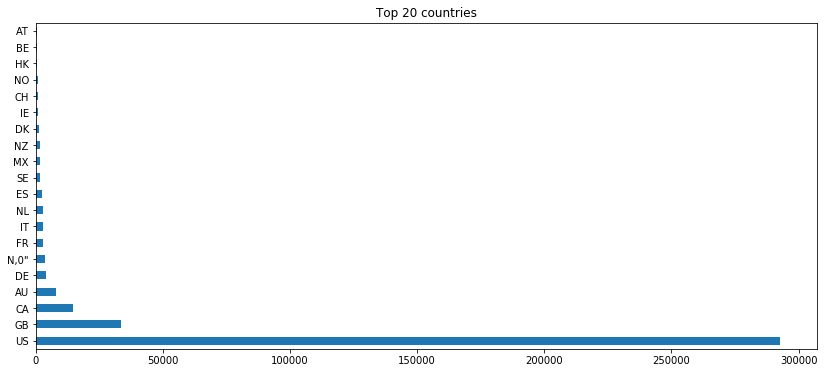

In [148]:
df_cloud['country'].value_counts()[:20].plot(kind='barh', 
                                       figsize=(14,6), 
                                       title='Top 20 countries')

In [149]:
#欠損値の確認
df_cloud.isnull().sum()

category                0
main_category           0
currency                0
goal                    0
pledged                 0
state                   0
backers                 0
country                 0
usd pledged          3797
usd_pledged_real        0
usd_goal_real           0
state_num           46986
dtype: int64

In [150]:
#欠損値データを削除
df_cloud.dropna(inplace=True)

In [151]:
# 質的変数のダミー変数化
# df_cloud = pd.get_dummies(df_cloud)

# 単純に実行するとカラム数が異常に多くなるため、対処法について検討要

In [152]:
# 相関係数を確認
df_cloud.corr()

,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real,state_num
goal,1.000000,0.007962,0.004792,0.006416,0.005949,0.952614,0.025097
pledged,0.007962,1.000000,0.718120,0.857966,0.953465,0.005716,-0.109563
backers,0.004792,0.718120,1.000000,0.697493,0.753221,0.005207,-0.125849
usd pledged,0.006416,0.857966,0.697493,1.000000,0.907713,0.006965,-0.095658
usd_pledged_real,0.005949,0.953465,0.753221,0.907713,1.000000,0.006349,-0.108359
usd_goal_real,0.952614,0.005716,0.005207,0.006965,0.006349,1.000000,0.023733
state_num,0.025097,-0.109563,-0.125849,-0.095658,-0.108359,0.023733,1.000000


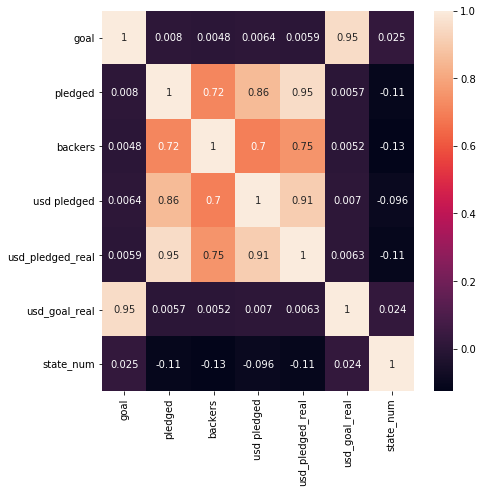

In [153]:
# 相関係数をヒートマップにして可視化
fig = plt.figure(figsize=(7, 7))
sns.heatmap(df_cloud.corr(), annot=True)
plt.show()

In [154]:
#評価対象のみに絞る
df_cloud_eval = df_cloud.loc[:, ['state_num', 'goal','pledged','backers','usd pledged','usd_pledged_real','usd_goal_real']]

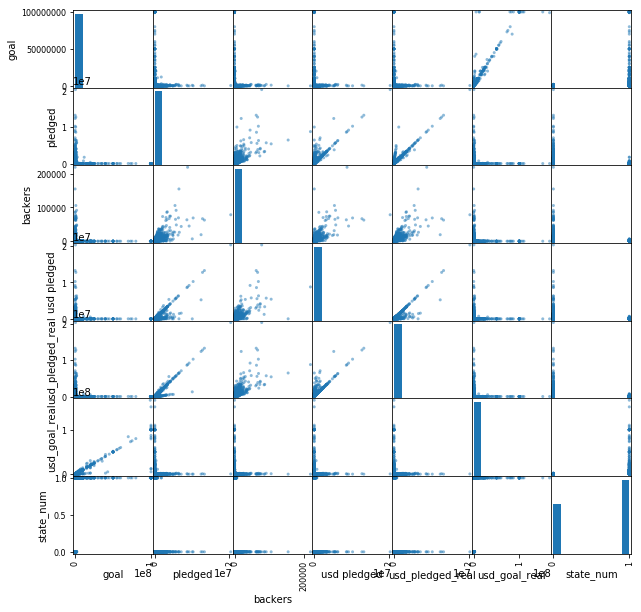

In [155]:
# 散布図行列を書いてみる
pd.plotting.scatter_matrix(df_cloud, figsize=(10,10))
plt.show()

In [156]:
y = df_cloud_eval["state_num"].values
X = df_cloud_eval.drop('state_num', axis=1).values
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1111, tol=1e-3)
clf.fit(X, y)

# 重みを取得して表示
w0 = clf.intercept_[0]
w1 = clf.coef_[0, 0]
w2 = clf.coef_[0, 1]
w3 = clf.coef_[0, 2]
w4 = clf.coef_[0, 3]
w5 = clf.coef_[0, 4]
w6 = clf.coef_[0, 5]

print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}, w4 = {:.3f}, w5 = {:.3f}, w6 = {:.3f}'.format(w0, w1, w2, w3, w4, w5, w6))

w0 = -41.020, w1 = 434266.467, w2 = -434307.390, w3 = -11979.246, w4 = 2310.611, w5 = -437917.736, w6 = 435405.834


In [157]:
# ラベルを予測
y_est = clf.predict(X)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_est)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y, y_est)))

対数尤度 = -0.001
正答率 = 99.996%


In [158]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y, y_est), 
                        index=['正解 = 成功', '正解 = 失敗'], 
                        columns=['予測 = 成功', '予測 = 失敗'])

conf_mat

,予測 = 成功,予測 = 失敗
正解 = 成功,133848,3
正解 = 失敗,9,197605


In [159]:
# ラベルを予測
y_pred = clf.predict(X)

# 正答率を計算
accuracy =  accuracy_score(y, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred)

# カテゴリ「成功」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

正答率（Accuracy） = 99.996%
適合率（Precision） = 99.993%
再現率（Recall） = 99.998%
F1値（F1-score） = 99.996%


# 日付の観点を調査

In [160]:
import datetime

df_date = pd.read_csv(
    "./input/ks-projects-201801.csv", delimiter = ",")[
    ['deadline', 'launched', 'state']]

In [161]:
df_date['period'] = (pd.to_datetime(df_date['deadline']) - pd.to_datetime(df_date['launched'])).dt.days + 1

In [162]:
df_date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 4 columns):
deadline    378661 non-null object
launched    378661 non-null object
state       378661 non-null object
period      378661 non-null int64
dtypes: int64(1), object(3)
memory usage: 11.6+ MB


In [136]:
print('失敗プロジェクトの平均期間: {0}日'
      .format(round(df_date[df_date['state'] == 'failed']['period'].mean(), 2)))
print('成功プロジェクトの平均期間: {0}日'
      .format(round(df_date[df_date['state'] == 'successful']['period'].mean(), 2)))

失敗プロジェクトの平均期間: 35.17日
成功プロジェクトの平均期間: 32.16日
